In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../result/result_max_per_gene_single.csv')
df

,Unnamed: 0,Δβ,gene
0,cg00134295,0.207143,A2M
1,cg15769388,-0.143162,A2ML1
2,cg13001012,-0.061497,AADAC
3,cg00150882,0.161237,AADAT
4,cg20940607,0.009252,AAGAB
...,...,...,...
7902,cg07135797,-0.288723,ZNRD1
7903,cg20080983,-0.261198,ZNRF3
7904,cg14231297,0.401591,ZSCAN18
7905,cg14642833,-0.017558,ZWINT


In [3]:
train = pd.read_csv('../champ_result/all_beta_normalized.csv')

In [4]:
df_gene = train[train['Unnamed: 0'].isin(df['Unnamed: 0'])]
df_gene.reset_index(drop=True, inplace=True)
print(df_gene.shape)
df_gene.head()

(7907, 891)


,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,881,882,883,884,885,886,887,888,889,890
0,cg00359395,0.550517,0.550517,0.225787,0.225787,0.418402,0.418402,0.409473,0.409473,0.391590,...,0.821967,0.821967,0.761213,0.761213,0.741267,0.741267,0.690491,0.690491,0.797197,0.797197
1,cg00465927,0.638461,0.638461,0.878949,0.878949,0.791181,0.791181,0.809978,0.809978,0.700933,...,0.945428,0.945428,0.892032,0.892032,0.910751,0.910751,0.919344,0.919344,0.894355,0.894355
2,cg00718333,0.071787,0.071787,0.053389,0.053389,0.050321,0.050321,0.060594,0.060594,0.038067,...,0.074939,0.074939,0.046640,0.046640,0.067187,0.067187,0.038098,0.038098,0.076852,0.076852
3,cg00962755,0.400554,0.400554,0.578978,0.578978,0.544175,0.544175,0.597802,0.597802,0.460621,...,0.924658,0.924658,0.882844,0.882844,0.652182,0.652182,0.924119,0.924119,0.783084,0.783084
4,cg01510813,0.119129,0.119129,0.140341,0.140341,0.180296,0.180296,0.155642,0.155642,0.104086,...,0.790514,0.790514,0.369087,0.369087,0.101004,0.101004,0.682093,0.682093,0.125836,0.125836


In [5]:
train_normal = df_gene.iloc[:,1:94:2]
train_tumor = df_gene.iloc[:,94::2]

train_tumor.columns=range(0,train_tumor.shape[1])
train_normal.columns=range(0,train_normal.shape[1])

train_tumor = train_tumor.T
train_normal = train_normal.T 

In [6]:
train_normal_avg = train_normal.mean(skipna=True, axis=0)

In [7]:
tt_dbeta=(train_tumor).subtract(train_normal_avg, axis = 1) 
tn_dbeta=(train_normal).subtract(train_normal_avg, axis = 1)

In [8]:
train_sensitivity = pd.DataFrame()
train_specificity = pd.DataFrame()
for i in np.arange(0.01,1,0.01):
    cp = i.__round__(2)
    TP = (tt_dbeta.abs() > cp).sum()
    FN = (tt_dbeta.abs() < cp).sum()
    FP = (tn_dbeta.abs() > cp).sum()
    TN = (tn_dbeta.abs() < cp).sum()
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)

    train_sensitivity = pd.concat([train_sensitivity, sensitivity], ignore_index=True, axis=1)
    train_specificity = pd.concat([train_specificity, specificity], ignore_index=True, axis=1)        

In [9]:
# Youden Index (J)
Approach_J = train_sensitivity + train_specificity - 1 
max_columns_J = Approach_J.idxmax(axis=1)
max_values_J = Approach_J.max(axis=1)

sen_J = train_sensitivity.melt().loc[max_columns_J.index].iloc[:,1]
spe_J = train_specificity.melt().loc[max_columns_J.index].iloc[:,1]

In [10]:
# Concordance Probability Method (CZ)
Approach_CZ = train_sensitivity * train_specificity
max_columns_CZ = Approach_CZ.idxmax(axis=1)
max_values_CZ = Approach_CZ.max(axis=1)

sen_CZ = train_sensitivity.melt().loc[max_columns_CZ.index].iloc[:,1]
spe_CZ = train_specificity.melt().loc[max_columns_CZ.index].iloc[:,1]

In [11]:
# Closest to (0,1) Criteria (ER)
Approach_ER = ((1-train_sensitivity)**2 + (1-train_specificity)**2)
Approach_ER = Approach_ER.apply(np.sqrt)
min_columns_ER = Approach_ER.idxmin(axis=1)
min_values_ER = Approach_ER.min(axis=1)

sen_ER = train_sensitivity.melt().loc[min_columns_ER.index].iloc[:,1]
spe_ER = train_specificity.melt().loc[min_columns_ER.index].iloc[:,1]

In [12]:
# F1 score
Approach_F1 = 2 * train_sensitivity * train_specificity / (train_sensitivity + train_specificity)
max_columns_F1 = Approach_F1.idxmax(axis=1)
max_values_F1 = Approach_F1.max(axis=1)

sen_F1 = train_sensitivity.melt().loc[max_columns_F1.index].iloc[:,1]
spe_F1 = train_specificity.melt().loc[max_columns_F1.index].iloc[:,1]

In [13]:
result_df = pd.DataFrame({
        'J': max_values_J, 
        'J cut-point': (max_columns_J+1)/100, 
        'J sensitivity': sen_J, 
        'J specificity': spe_J, 
        'CZ': max_values_CZ,
        'CZ cut-point': (max_columns_CZ+1)/100,
        'CZ sensitivity': sen_CZ,
        'CZ specificity': spe_CZ,
        'ER': min_values_ER,
        'ER cut-point': (min_columns_ER+1)/100,
        'ER sensitivity': sen_ER,
        'ER specificity': spe_ER,
        'F1': max_values_F1,
        'F1 cut-point': (max_columns_F1+1)/100,
        'F1 sensitivity': sen_F1,
        'F1 specificity': spe_F1,
    })
result_df

,J,J cut-point,J sensitivity,J specificity,CZ,CZ cut-point,CZ sensitivity,CZ specificity,ER,ER cut-point,ER sensitivity,ER specificity,F1,F1 cut-point,F1 sensitivity,F1 specificity
0,0.742015,0.16,1.000000,0.063830,0.758652,0.16,1.000000,0.063830,0.182433,0.16,1.000000,0.063830,0.871005,0.16,1.000000,0.063830
1,0.584120,0.14,0.979950,0.042553,0.620914,0.14,0.979950,0.042553,0.315227,0.14,0.979950,0.042553,0.783923,0.14,0.979950,0.042553
2,0.272436,0.01,0.676692,0.595745,0.403135,0.01,0.676692,0.595745,0.517639,0.01,0.676692,0.595745,0.633643,0.01,0.676692,0.595745
3,0.804671,0.12,0.994987,0.085106,0.813310,0.12,0.994987,0.085106,0.144486,0.12,0.994987,0.085106,0.901339,0.12,0.994987,0.085106
4,0.580280,0.09,0.957393,0.148936,0.602997,0.09,0.957393,0.148936,0.340158,0.05,0.957393,0.148936,0.763152,0.09,0.957393,0.148936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,0.559057,0.09,0.962406,0.234043,0.599051,0.09,0.962406,0.234043,0.323312,0.06,0.962406,0.234043,0.771411,0.06,0.962406,0.234043
7903,0.221245,0.05,0.942356,0.148936,0.368794,0.07,0.942356,0.148936,0.557449,0.07,0.942356,0.148936,0.604651,0.07,0.942356,0.148936
7904,0.367461,0.12,0.967419,0.063830,0.462326,0.11,0.967419,0.063830,0.454704,0.11,0.967419,0.063830,0.678643,0.11,0.967419,0.063830
7905,0.819602,0.10,0.984962,0.106383,0.825468,0.10,0.984962,0.106383,0.144263,0.10,0.984962,0.106383,0.907306,0.10,0.984962,0.106383


In [14]:
test = pd.read_csv('../champ_result/all_beta_normalized_test.csv')

In [15]:
df_gene = test[test['Unnamed: 0'].isin(df['Unnamed: 0'])]
df_gene.reset_index(drop=True, inplace=True)
print(df_gene.shape)
df_gene.head()

(7907, 901)


,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,900
0,cg00359395,0.627596,0.627596,0.586939,0.586939,0.570612,0.570612,0.535554,0.535554,0.468399,...,0.817953,0.817953,0.634996,0.634996,0.796298,0.796298,0.723925,0.723925,0.761481,0.761481
1,cg00465927,0.668758,0.668758,0.686614,0.686614,0.647277,0.647277,0.820267,0.820267,0.707856,...,0.918746,0.918746,0.884158,0.884158,0.928632,0.928632,0.935184,0.935184,0.877917,0.877917
2,cg00718333,0.080446,0.080446,0.093193,0.093193,0.090103,0.090103,0.087472,0.087472,0.089152,...,0.079004,0.079004,0.066632,0.066632,0.035408,0.035408,0.068256,0.068256,0.067688,0.067688
3,cg00962755,0.562169,0.562169,0.631922,0.631922,0.508663,0.508663,0.708099,0.708099,0.559470,...,0.820346,0.820346,0.821079,0.821079,0.869187,0.869187,0.870217,0.870217,0.751299,0.751299
4,cg01510813,0.122091,0.122091,0.154046,0.154046,0.195271,0.195271,0.167329,0.167329,0.088180,...,0.158430,0.158430,0.428894,0.428894,0.483994,0.483994,0.316074,0.316074,0.158220,0.158220


In [16]:
test_normal = df_gene.iloc[:,2:102:2]
test_tumor = df_gene.iloc[:,102::2]

test_tumor.columns=range(0,test_tumor.shape[1])
test_normal.columns=range(0,test_normal.shape[1])

test_tumor = test_tumor.T
test_normal = test_normal.T 

In [17]:
# Computing IQR
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    upper_fence=Q3+IQR*1.5
    lower_fence=Q1-IQR*1.5
    return upper_fence,lower_fence
def no_outlier(df):
    upper_fence,lower_fence=IQR(df)
    ddf=df[(df>lower_fence)&(df<upper_fence)]
    return ddf

In [18]:
test_tumor = no_outlier(test_tumor)
test_normal = no_outlier(test_normal)

In [19]:
test_normal_avg = test_normal.mean(skipna=True, axis=0)

In [20]:
ttt_dbeta=(test_tumor).subtract(test_normal_avg, axis = 1)
ttn_dbeta=(test_normal).subtract(test_normal_avg, axis = 1)

In [21]:
cp_list = ['J cut-point', 'CZ cut-point', 'ER cut-point', 'F1 cut-point']
df_cpc = result_df[cp_list]
test_sensitivity = pd.DataFrame()
test_specificty = pd.DataFrame()

for i in range(0, df_cpc.shape[1]):
    cp = df_cpc[cp_list[i]]
    TP = (ttt_dbeta.abs() > cp).sum()
    FN = (ttt_dbeta.abs() < cp).sum()
    FP = (ttn_dbeta.abs() > cp).sum()
    TN = (ttn_dbeta.abs() < cp).sum()
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    test_sensitivity = pd.concat([test_sensitivity, sensitivity], ignore_index=True, axis=1)
    test_specificty = pd.concat([test_specificty, specificity], ignore_index=True, axis=1)
    
test_sensitivity.columns = cp_list
test_specificty.columns = cp_list

In [22]:
print(test_sensitivity.shape)
test_sensitivity.head(6)

(7907, 4)


,J cut-point,CZ cut-point,ER cut-point,F1 cut-point
0,0.642132,0.642132,0.642132,0.642132
1,0.885246,0.885246,0.885246,0.885246
2,0.707692,0.707692,0.707692,0.707692
3,0.952128,0.952128,0.952128,0.952128
4,0.662500,0.662500,0.832500,0.662500
5,0.588832,0.588832,0.588832,0.588832


In [23]:
print(test_specificty.shape)
test_specificty.head(6)

(7907, 4)


,J cut-point,CZ cut-point,ER cut-point,F1 cut-point
0,1.000000,1.000000,1.000000,1.000000
1,0.860000,0.860000,0.860000,0.860000
2,0.220000,0.220000,0.220000,0.220000
3,0.857143,0.857143,0.857143,0.857143
4,0.854167,0.854167,0.562500,0.854167
5,0.914894,0.914894,0.914894,0.914894


In [24]:
import numpy as np
def J_method(sen, spe):
    J = sen + spe - 1
    return J
def CZ_method(sen, spe):
    CZ = sen * spe 
    return CZ
def ER_method(sen, spe):
    ER = (1-sen)**2 + (1-spe)**2
    ER = ER.apply(np.sqrt)
    return ER
def UI_method(sen, spe, auc):
    UI = abs(sen.subtract(auc, axis=0)) + abs(spe.subtract(auc, axis=0))
    return UI
def F1_method(sen, spe):
    F1 = 2 * sen * spe / (sen + spe)
    return F1

In [25]:
J = J_method(test_sensitivity, test_specificty)
CZ = CZ_method(test_sensitivity, test_specificty)
ER = ER_method(test_sensitivity, test_specificty)
F1 = F1_method(test_sensitivity, test_specificty)

In [26]:
df_cross_validation = pd.concat([J, CZ, ER,F1],keys = ['J', 'CZ', 'ER','F1'], axis=1)
# merge two level of columns
df_cross_validation.columns = df_cross_validation.columns.map(','.join)
df_cross_validation.columns = df_cross_validation.columns.str.replace(' cut-point', '')
print(df_cross_validation.shape)
df_cross_validation.head()

(7907, 16)


,"J,J","J,CZ","J,ER","J,F1","CZ,J","CZ,CZ","CZ,ER","CZ,F1","ER,J","ER,CZ","ER,ER","ER,F1","F1,J","F1,CZ","F1,ER","F1,F1"
0,0.642132,0.642132,0.642132,0.642132,0.642132,0.642132,0.642132,0.642132,0.357868,0.357868,0.357868,0.357868,0.782071,0.782071,0.782071,0.782071
1,0.745246,0.745246,0.745246,0.745246,0.761311,0.761311,0.761311,0.761311,0.181021,0.181021,0.181021,0.181021,0.872440,0.872440,0.872440,0.872440
2,-0.072308,-0.072308,-0.072308,-0.072308,0.155692,0.155692,0.155692,0.155692,0.832973,0.832973,0.832973,0.832973,0.335655,0.335655,0.335655,0.335655
3,0.809271,0.809271,0.809271,0.809271,0.816109,0.816109,0.816109,0.816109,0.150665,0.150665,0.150665,0.150665,0.902142,0.902142,0.902142,0.902142
4,0.516667,0.516667,0.395000,0.516667,0.565885,0.565885,0.468281,0.565885,0.367660,0.367660,0.468468,0.367660,0.746223,0.746223,0.671371,0.746223


In [27]:
df_cross_validation = pd.concat([df, df_cross_validation], axis=1)
df_cross_validation

,Unnamed: 0,Δβ,gene,"J,J","J,CZ","J,ER","J,F1","CZ,J","CZ,CZ","CZ,ER","CZ,F1","ER,J","ER,CZ","ER,ER","ER,F1","F1,J","F1,CZ","F1,ER","F1,F1"
0,cg00134295,0.207143,A2M,0.642132,0.642132,0.642132,0.642132,0.642132,0.642132,0.642132,0.642132,0.357868,0.357868,0.357868,0.357868,0.782071,0.782071,0.782071,0.782071
1,cg15769388,-0.143162,A2ML1,0.745246,0.745246,0.745246,0.745246,0.761311,0.761311,0.761311,0.761311,0.181021,0.181021,0.181021,0.181021,0.872440,0.872440,0.872440,0.872440
2,cg13001012,-0.061497,AADAC,-0.072308,-0.072308,-0.072308,-0.072308,0.155692,0.155692,0.155692,0.155692,0.832973,0.832973,0.832973,0.832973,0.335655,0.335655,0.335655,0.335655
3,cg00150882,0.161237,AADAT,0.809271,0.809271,0.809271,0.809271,0.816109,0.816109,0.816109,0.816109,0.150665,0.150665,0.150665,0.150665,0.902142,0.902142,0.902142,0.902142
4,cg20940607,0.009252,AAGAB,0.516667,0.516667,0.395000,0.516667,0.565885,0.565885,0.468281,0.565885,0.367660,0.367660,0.468468,0.367660,0.746223,0.746223,0.671371,0.746223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,cg07135797,-0.288723,ZNRD1,0.638367,0.638367,0.511378,0.511378,0.661224,0.661224,0.567245,0.567245,0.291657,0.291657,0.356395,0.356395,0.807175,0.807175,0.750633,0.750633
7903,cg20080983,-0.261198,ZNRF3,-0.081809,-0.178862,-0.178862,-0.178862,0.210366,0.102981,0.102981,0.102981,0.765481,0.908862,0.908862,0.908862,0.458218,0.250825,0.250825,0.250825
7904,cg14231297,0.401591,ZSCAN18,0.401855,0.398527,0.398527,0.398527,0.487070,0.486907,0.486907,0.486907,0.432836,0.430128,0.430128,0.430128,0.694894,0.696314,0.696314,0.696314
7905,cg14642833,-0.017558,ZWINT,0.818723,0.818723,0.818723,0.818723,0.822128,0.822128,0.822128,0.822128,0.161408,0.161408,0.161408,0.161408,0.904071,0.904071,0.904071,0.904071


In [50]:
# calculate correlation between J,J	and J,CZ
J_cor = [
    df_cross_validation['J,J'].corr(df_cross_validation['J,J']),
    df_cross_validation['J,J'].corr(df_cross_validation['J,CZ']),
    df_cross_validation['J,J'].corr(df_cross_validation['J,ER']),
    df_cross_validation['J,J'].corr(df_cross_validation['J,F1'])]
CZ_cor = [
    df_cross_validation['J,CZ'].corr(df_cross_validation['J,J']),
    df_cross_validation['J,CZ'].corr(df_cross_validation['J,CZ']),
    df_cross_validation['J,CZ'].corr(df_cross_validation['J,ER']),
    df_cross_validation['J,CZ'].corr(df_cross_validation['J,F1'])]
ER_cor = [
    df_cross_validation['J,ER'].corr(df_cross_validation['J,J']),
    df_cross_validation['J,ER'].corr(df_cross_validation['J,CZ']),
    df_cross_validation['J,ER'].corr(df_cross_validation['J,ER']),
    df_cross_validation['J,ER'].corr(df_cross_validation['J,F1'])]
F1_cor = [
    df_cross_validation['J,F1'].corr(df_cross_validation['J,J']),
    df_cross_validation['J,F1'].corr(df_cross_validation['J,CZ']),
    df_cross_validation['J,F1'].corr(df_cross_validation['J,ER']),
    df_cross_validation['J,F1'].corr(df_cross_validation['J,F1'])]

 
J_cor += J_cor[:1]
CZ_cor += CZ_cor[:1]
ER_cor += ER_cor[:1]
F1_cor += F1_cor[:1]

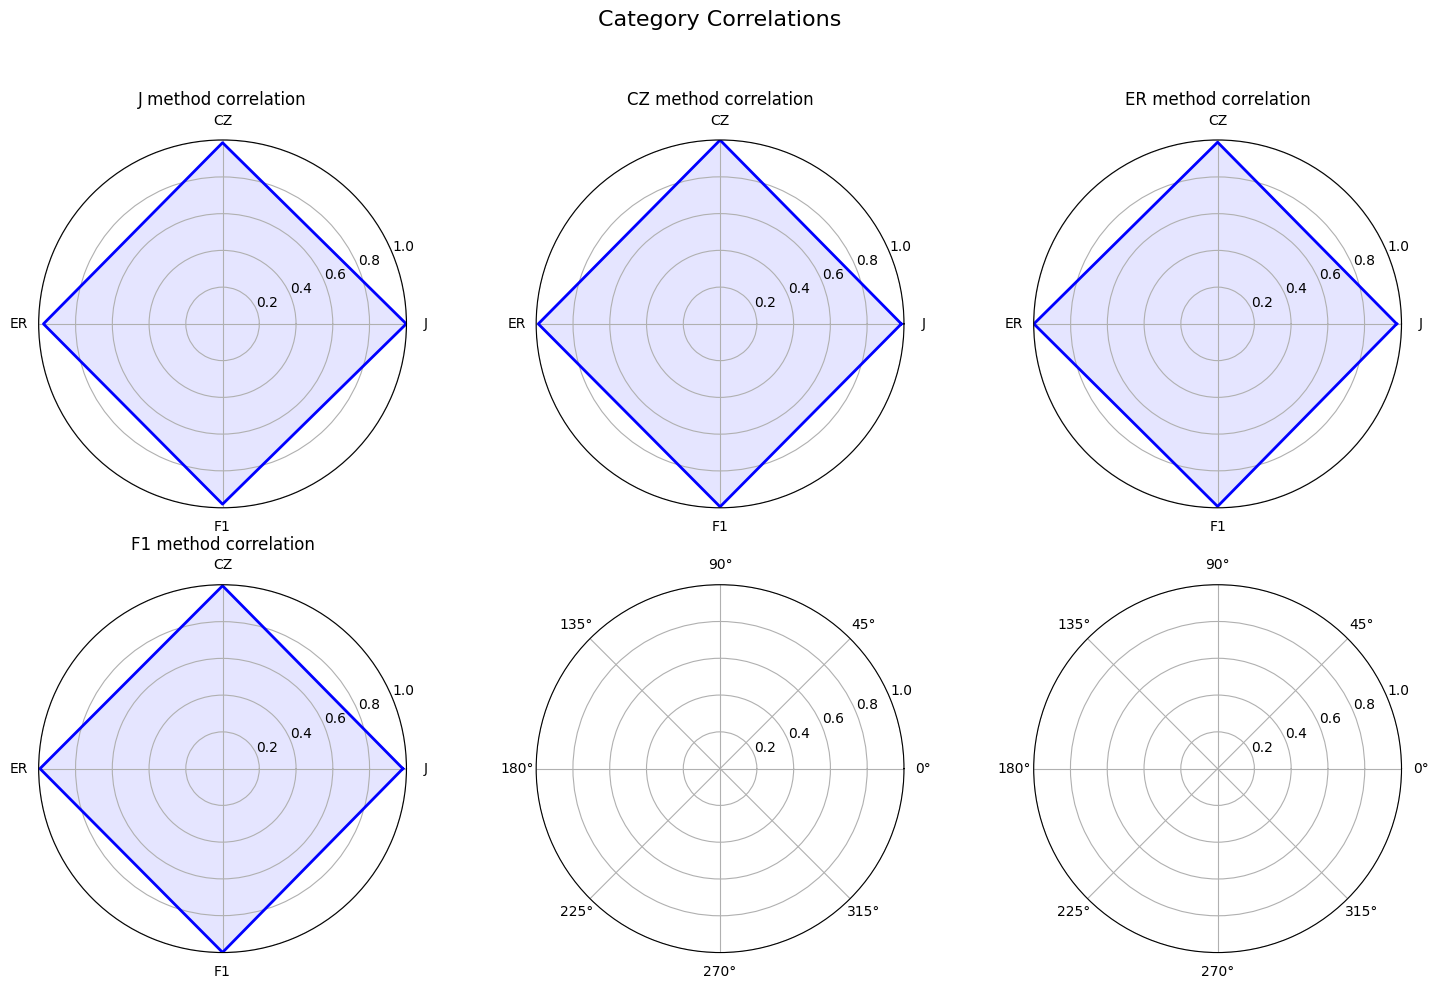

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for the five categories

categories = ['J', 'CZ', 'ER', 'F1']
num_categories = len(categories)
# Create an array of evenly spaced angles to represent each category
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
angles += angles[:1]

# Create a figure with 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(polar=True))
fig.suptitle('Category Correlations', fontsize=16)

# Loop through the categories and create subplots
for i, (ax, category) in enumerate(zip(axes.flatten(), categories)):
    
    ax.fill(angles, eval(f'{category}_cor'), 'b', alpha=0.1)
    ax.plot(angles, eval(f'{category}_cor'), 'b', linewidth=2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(f'{category} method correlation')

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


In [61]:
dmp = pd.read_csv('../champ_result/DMP_result_test.csv')
# remove gene columns
dmp = dmp.drop(dmp.columns[-10], axis=1)

In [79]:
merge = pd.merge(df_cross_validation, dmp, on='Unnamed: 0', how='left')

these poor biomarker is not in champ_dmp using test data, so say bye bye

In [80]:
# leave those have nan in DMP
nan = merge[merge['feature'].isnull()]
nan.dropna(axis=1, inplace=True)
nan = nan[['Unnamed: 0','gene']]
nan

C:\Users\Vincent\AppData\Local\Temp\ipykernel_12100\1565340991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan.dropna(axis=1, inplace=True)


,Unnamed: 0,gene
28,cg01324343,ABCC5
31,cg01306662,ABCE1
53,cg24079790,ACAT1
67,cg26398848,ACP1
80,cg04490349,ACTB
...,...,...
7878,cg03884783,ZNF569
7882,cg27614445,ZNF639
7889,cg20671910,ZNF687
7892,cg18440048,ZNF70


In [81]:
nan.to_csv('../result/result_max_per_gene_single_nan.csv', index=False)

In [82]:
# drop row with nan in feature
merge.dropna(subset=['feature'], inplace=True)
merge

,Unnamed: 0,Δβ,gene,"J,J","J,CZ","J,ER","J,F1","CZ,J","CZ,CZ","CZ,ER",...,Type,feature,cgi,feat.cgi,UCSC_CpG_Islands_Name,DHS,Enhancer,Phantom,Probe_SNPs,Probe_SNPs_10
0,cg00134295,0.207143,A2M,0.642132,0.642132,0.642132,0.642132,0.642132,0.642132,0.642132,...,II,TSS1500,opensea,TSS1500-opensea,NaN,NaN,True,NaN,NaN,NaN
1,cg15769388,-0.143162,A2ML1,0.745246,0.745246,0.745246,0.745246,0.761311,0.761311,0.761311,...,II,TSS1500,opensea,TSS1500-opensea,NaN,NaN,NaN,NaN,NaN,NaN
2,cg13001012,-0.061497,AADAC,-0.072308,-0.072308,-0.072308,-0.072308,0.155692,0.155692,0.155692,...,II,TSS1500,opensea,TSS1500-opensea,NaN,NaN,NaN,NaN,rs76177058,rs74351802
3,cg00150882,0.161237,AADAT,0.809271,0.809271,0.809271,0.809271,0.816109,0.816109,0.816109,...,II,TSS1500,island,TSS1500-island,chr4:171010943-171011503,NaN,NaN,NaN,NaN,NaN
4,cg20940607,0.009252,AAGAB,0.516667,0.516667,0.395000,0.516667,0.565885,0.565885,0.468281,...,II,1stExon,island,1stExon-island,chr15:67546789-67547410,NaN,NaN,high-CpG:65334022-65334062,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,cg07135797,-0.288723,ZNRD1,0.638367,0.638367,0.511378,0.511378,0.661224,0.661224,0.567245,...,II,Body,shore,Body-shore,chr6:30028936-30029195,NaN,NaN,NaN,rs10745,NaN
7903,cg20080983,-0.261198,ZNRF3,-0.081809,-0.178862,-0.178862,-0.178862,0.210366,0.102981,0.102981,...,II,Body,shelf,Body-shelf,chr22:29426510-29426843,NaN,NaN,NaN,NaN,NaN
7904,cg14231297,0.401591,ZSCAN18,0.401855,0.398527,0.398527,0.398527,0.487070,0.486907,0.486907,...,I,TSS200,island,TSS200-island,chr19:58629309-58630241,NaN,NaN,NaN,rs8109359,NaN
7905,cg14642833,-0.017558,ZWINT,0.818723,0.818723,0.818723,0.818723,0.822128,0.822128,0.822128,...,II,TSS1500,shore,TSS1500-shore,chr10:58121059-58121275,NaN,NaN,NaN,rs76761626,rs35989462


In [83]:
merge.to_csv('../result/result_test_cut_point_cross_vali_dmptest.csv', index=False)